# Assignment 4: Markov Decision Process - Forest Fire - Large

## Author: Vivek Agrawal (vagrwal63)
This file will provide analysis of MDP for Forest Fire

A forest is managed by two actions – WAIT and CUT. An action is decided each year with two objectives: maintain the forest for wildlife (i.e. WAIT) or cut the forest for wood (i.e. CUT). The Agent gets a reward of $1 for cutting the forest and going back to Initial State. However, the agent can decide to wait and hope for a better reward and move through states with a probability p in the hope of catching the maximum reward in final state. However, there is a probability of (1-p) that the forest will burn down and the agent will lose the reward as the forest goes back to initial state. 

In [1]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.example import forest
import numpy as np
from numpy.random import choice
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
np.random.seed(100)
P, R = forest(S=500, r1=100, r2= 25, p=0.01)

In [3]:
def test_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode


In [4]:
def plot_chart(x_axis_data, y_axis_data, title, ylabel, xlabel = "Discount Rate", color = 'b'):

    #plt.ylim((0.5, 1.05))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_axis_data, y_axis_data, 'o-', color=color, lw=2)
    #plt.legend(loc="best")
    #plt.legend(loc=3)
    plt.grid(True, linestyle = "--")
    plt.show()

In [17]:
def plot_ql_chart(x_axis_data, series1, series2, series3, title, ylabel, xlabel = "Discount Rate"):

    #plt.ylim((0.5, 1.05))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_axis_data, series1, 'o-', color='orange', lw=2, label = '1 Mill Iters')
    plt.plot(x_axis_data, series2, 'o-', color='blue', lw=2, label = '2 Mill Iters')
    plt.plot(x_axis_data, series3, 'o-', color='green', lw=2, label = '5 Mill Iters')
    plt.legend(loc="best")
    #plt.legend(loc=3)
    plt.grid(True, linestyle = "--")
    plt.show()

## Policy Iteration

In [5]:
def policy_iteration(P, R, discount = [0.9]):
    df_pi = pd.DataFrame(columns=["Discount", "Iteration", "Time", "Reward", "Policy"])
    for disc in discount:
        pi = PolicyIteration(P, R, gamma=disc, max_iter=1e6)
        pi.run()
        reward = test_policy(P, R, pi.policy)
        info = [disc, pi.iter, pi.time, reward, pi.policy]
        df_length = len(df_pi)
        df_pi.loc[df_length] = info
    return df_pi

In [6]:
df_pi = policy_iteration(P, R, discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

In [7]:
df_pi
df_pi.to_csv('./mdp/FF-500-PI.csv')

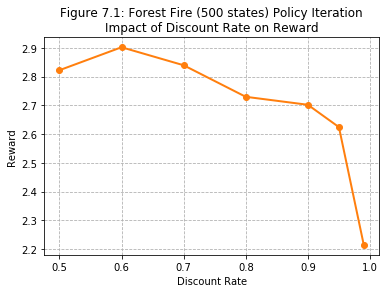

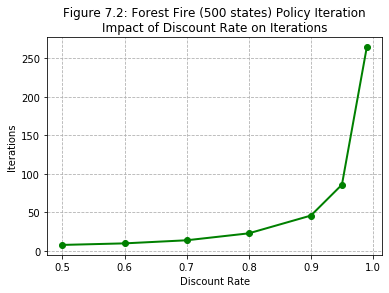

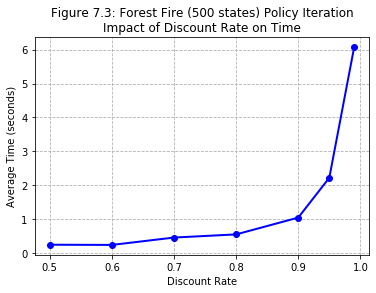

In [8]:
plot_chart(df_pi['Discount'], df_pi['Reward'], 
           "Figure 7.1: Forest Fire (500 states) Policy Iteration\nImpact of Discount Rate on Reward", "Reward", 
           xlabel = "Discount Rate", color = 'tab:orange')

plot_chart(df_pi['Discount'], df_pi['Iteration'], 
           "Figure 7.2: Forest Fire (500 states) Policy Iteration\nImpact of Discount Rate on Iterations", "Iterations", 
           xlabel = "Discount Rate", color = 'g')

plot_chart(df_pi['Discount'], df_pi['Time'], 
           "Figure 7.3: Forest Fire (500 states) Policy Iteration\nImpact of Discount Rate on Time", "Average Time (seconds)", 
           xlabel = "Discount Rate", color = 'b')


## Value Iteration

In [9]:
def value_iteration(P, R, discount = [0.9], eps = [1e-8]):
    df_vi = pd.DataFrame(columns=["Discount", "Policy", "Iteration", 
                                  "Time", "Reward", "Value Function"])
    for disc in discount:
        vi = ValueIteration(P, R, gamma=disc, epsilon=eps[0], max_iter=int(1e15))
        vi.run()
        reward = test_policy(P, R, vi.policy)
        info = [float(disc), vi.policy, vi.iter, vi.time, reward, vi.V]
        df_length = len(df_vi)
        df_vi.loc[df_length] = info
    return df_vi

In [10]:
df_vi = value_iteration(P, R, discount = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], eps=[1e-8])

In [19]:
df_vi
df_vi.to_csv('./mdp/FF-500-VI.csv')

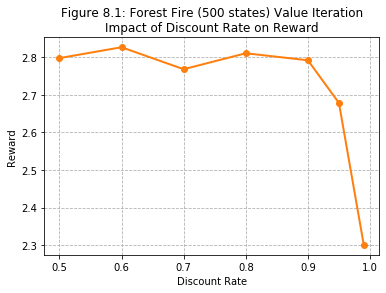

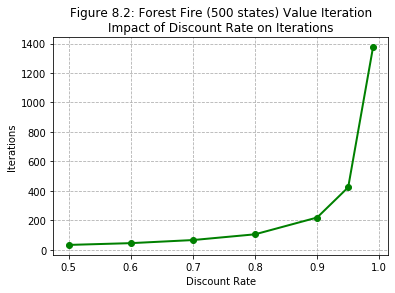

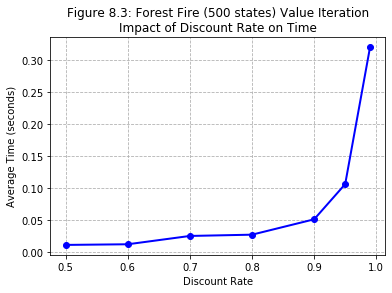

In [12]:
plot_chart(df_vi['Discount'], df_vi['Reward'], 
           "Figure 8.1: Forest Fire (500 states) Value Iteration\nImpact of Discount Rate on Reward", "Reward", 
           xlabel = "Discount Rate", color = 'tab:orange')

plot_chart(df_vi['Discount'], df_vi['Iteration'], 
           "Figure 8.2: Forest Fire (500 states) Value Iteration\nImpact of Discount Rate on Iterations", "Iterations", 
           xlabel = "Discount Rate", color = 'g')

plot_chart(df_vi['Discount'], df_vi['Time'], 
           "Figure 8.3: Forest Fire (500 states) Value Iteration\nImpact of Discount Rate on Time", "Average Time (seconds)", 
           xlabel = "Discount Rate", color = 'b')


## Q-Learning

In [13]:
def q_learning(P, R, epsilon, discount=[0.9], n_iter=[1000000]):
    df_ql = pd.DataFrame(columns=["Iterations", "Discount", "Reward", "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for disc in discount:
            q = QLearning(P, R, disc, epsilon = epsilon, n_iter = i)
            q.run()
            reward = test_policy(P, R, q.policy)
            count += 1
            print("{}: {}".format(count, reward))
            st = q.run_stats
            t_rewards = [s['Reward'] for s in st]
            info = [i, disc, reward, q.time, q.policy, q.V, t_rewards]

            df_length = len(df_ql)
            df_ql.loc[df_length] = info
    return df_ql

In [14]:
iterations =  [1000000, 2000000, 5000000]
discounts = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]
df_ql = q_learning(P, R, 1.0, discount=discounts, n_iter=iterations)

1: 2.6334652586978113
2: 2.677018476870458
3: 0.866
4: 2.6260512922561516
5: 2.622224287159526
6: 2.6171435277311037
7: 2.591962954768582
8: 2.554293742821558
9: 2.7508518399342905
10: 2.8098917508877195
11: 2.7246280089767336
12: 0.928
13: 2.7249687020479043
14: 2.777750289167815
15: 2.7109056937825655
16: 2.721483700160406
17: 2.7999890540223498
18: 2.7926921413794368
19: 2.680895903778262
20: 2.8303510464031745
21: 2.7945894292214257
22: 2.704131192690248
23: 2.708270722166356
24: 2.8131734613759227


In [16]:
df_ql.to_csv('./mdp/FF-500-QL.csv')

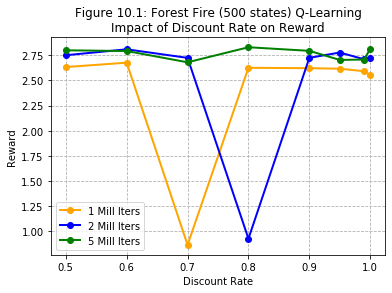

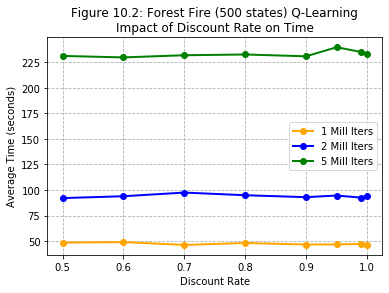

In [18]:
df1 = df_ql[df_ql.Iterations == 1000000]
df2 = df_ql[df_ql.Iterations == 2000000]
df3 = df_ql[df_ql.Iterations == 5000000]


plot_ql_chart(df1['Discount'], df1['Reward'], df2['Reward'], df3['Reward'],
           "Figure 10.1: Forest Fire (500 states) Q-Learning\nImpact of Discount Rate on Reward", "Reward", 
           xlabel = "Discount Rate")

plot_ql_chart(df1['Discount'], df1['Time'], df2['Time'], df3['Time'], 
           "Figure 10.2: Forest Fire (500 states) Q-Learning\nImpact of Discount Rate on Time", "Average Time (seconds)", 
           xlabel = "Discount Rate")

In [20]:
df1.to_csv('./mdp/FF-500_df1.csv')